In [11]:
import warnings
warnings.filterwarnings("ignore")
from utils.dataset import TextDataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch import nn
import torch
from utils.model import LSTMnet_RnnAtten
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pandas as pd

In [12]:
import os
print(os.getcwd())

train_annotations = '..\\data\\MELD\\train_sent_emo.csv'
val_annotations = '..\\data\\\MELD\\dev_sent_emo.csv'
test_annotations = '..\\data\\MELD\\test_sent_emo.csv'

train_bert = 'embeddings\\bert_embeddings'
val_bert = 'embeddings\\bert_embeddings_val'
test_bert = 'embeddings\\bert_embeddings_test'


c:\Users\kjart\OneDrive\Dokumenter\KU\2. semester\CogSci2\research\multimodal\text_only


In [13]:
train = TextDataset(train_annotations, train_bert)
val = TextDataset(val_annotations, val_bert)

# train, val = train_test_split(train, test_size=0.2)

train_dataloader = DataLoader(train, batch_size=64, shuffle = True, drop_last=False)
val_dataloader = DataLoader(val, batch_size=64, shuffle=True, drop_last=False)
train_features, train_labels = next(iter(train_dataloader))

In [14]:
# Sanity check: Size should be [batch_size, num_features, feature_vector_len], [batch_size]
# Where batch size is 32, num_features (num mfccs) is 40 
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
features = train_features[0]
label = train_labels[0]

features.shape,label


Feature batch shape: torch.Size([64, 768])
Labels batch shape: torch.Size([64])


(torch.Size([768]), tensor(4))

In [15]:
for batch in train_dataloader:
    x, y = batch
    print(x.shape, y.shape)
    break

torch.Size([64, 768]) torch.Size([64])


In [16]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)

In [17]:
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits = model(X)
        predictions = torch.argmax(output_logits,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
        # compute loss
        loss = loss_fnc(output_logits, Y)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100 , f1*100
    return train_step

In [18]:
def make_validate_fnc(model,loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits = model(X)
            predictions = torch.argmax(output_logits,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, predictions, f1*100
    return validate

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LSTMnet_RnnAtten(input_dim = 768, hidden_dim=128, output_dim=7, num_layers=3).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )
OPTIMIZER = torch.optim.Adam(model.parameters(),lr=0.0001/2, weight_decay=1e-2)


Number of trainable params:  823815


In [20]:
train_step = make_train_step(model, loss_fnc, optimizer=OPTIMIZER)
validate = make_validate_fnc(model,loss_fnc)

val_accs = []
losses=[]
val_losses = []
f1s = []
val_f1s= []
epochs = 120
best_val_f1 = 0


for epoch in range(epochs):
    epoch_acc = 0
    epoch_loss = 0
    epoch_f1 = 0
    for idx, (features, labels) in enumerate(train_dataloader):
        X, Y = features, labels
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        loss, acc, f1= train_step(X_tensor,Y_tensor)
        epoch_acc += acc*len(features)/len(train)
        epoch_loss += loss*len(features)/len(train)
        epoch_f1 += f1*len(features)/len(train)
    for batch in val_dataloader:
        X_val, Y_val = batch
        break
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
    val_loss, val_acc, _, val_f1 = validate(X_val_tensor,Y_val_tensor)
    val_accs.append(val_acc.cpu())
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    f1s.append(epoch_f1)
    val_f1s.append(val_f1)
    if val_f1 > best_val_f1:
        torch.save(model.state_dict(), 'best-model-parameters.pt')
        best_epoch = epoch
        best_val_f1 = val_f1
    
    print('')
    print(f"Epoch {epoch+1} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%  f1:{f1:.2f}%, val_f1:{val_f1:.2f}%")


Epoch 1 --> loss:1.8899, acc:24.37%, val_loss:1.7927, val_acc:46.88%  f1:13.33%, val_f1:29.92%

Epoch 2 --> loss:1.7058, acc:44.91%, val_loss:1.6190, val_acc:42.19%  f1:26.67%, val_f1:25.03%

Epoch 3 --> loss:1.6168, acc:46.70%, val_loss:1.6124, val_acc:50.00%  f1:71.11%, val_f1:33.33%

Epoch 4 --> loss:1.5741, acc:47.16%, val_loss:1.6464, val_acc:37.50%  f1:6.67%, val_f1:20.45%

Epoch 5 --> loss:1.5463, acc:47.16%, val_loss:1.7556, val_acc:31.25%  f1:100.00%, val_f1:16.41%

Epoch 6 --> loss:1.5258, acc:47.15%, val_loss:1.6362, val_acc:40.62%  f1:6.67%, val_f1:25.54%

Epoch 7 --> loss:1.5072, acc:47.40%, val_loss:1.5981, val_acc:37.50%  f1:6.67%, val_f1:23.42%

Epoch 8 --> loss:1.4867, acc:47.40%, val_loss:1.5782, val_acc:40.62%  f1:0.00%, val_f1:26.53%

Epoch 9 --> loss:1.4611, acc:48.67%, val_loss:1.4779, val_acc:50.00%  f1:22.86%, val_f1:35.07%

Epoch 10 --> loss:1.4337, acc:49.69%, val_loss:1.5030, val_acc:45.31%  f1:0.00%, val_f1:34.40%

Epoch 11 --> loss:1.4140, acc:50.90%, val_

layers:  3
model hidden dim:  128
batch size:  64


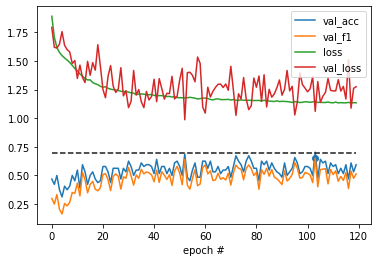

In [21]:
import matplotlib.pyplot as plt
x = range(epochs)

fig, ax = plt.subplots()
ax.set_xlabel('epoch #')
ax.set_ylabel('')
ax.plot(x,np.divide(val_accs,100), label='val_acc')
ax.plot(x,np.divide(val_f1s,100), label='val_f1')
ax.plot(x, losses, label='loss')
ax.plot(x, val_losses, label='val_loss')
ax.scatter(best_epoch, best_val_f1/100)
ax.plot(x, 0.7*np.ones(len(x)), '--', color=(0.1,0.1,0.1))
ax.legend()
print("layers: ", model.num_layers)
print("model hidden dim: ", model.hidden_dim)
print("batch size: ", train_dataloader.batch_size)



In [22]:

model.load_state_dict(torch.load("best-model-parameters.pt"))

<All keys matched successfully>

In [23]:

test = TextDataset(test_annotations, test_bert)
test_dataloader = DataLoader(test, batch_size=len(test), shuffle=True, drop_last=False)

device = 'cpu'
model.to(device)

for idx, (features, labels) in enumerate(test_dataloader):
    X, Y = features, labels
    X_tensor = torch.tensor(X,device=device).float()
    Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
    output_logits = model(X)
    predictions = torch.argmax(output_logits,dim=1)
   
    f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
    
print(f1)


0.556550646960082
